In [15]:
%pylab inline

import pandas as pd
import pandas_datareader.data as web
import core

rcParams['figure.figsize'] = (12,8)
rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [67]:
from importlib import reload
reload(core)

<module 'core' from '/Users/isaacdrachman/Documents/GitHub/Gradient/core.py'>

In [68]:
df = web.DataReader('^GSPC', 'yahoo', '2000-10-03', '2019-10-03').Close

In [80]:
def capped_uncapped(S_t, K, cap, spread, vega_n, const_var=True):
    var_n = vega_n / (2*K) * 100
    uncapped = core.variance_swap_payout(S_t,K,var_n=var_n)
    if not const_var:
        var_n = vega_n / (2*(K-spread)) * 100
    capped   = core.variance_swap_payout(S_t,K-spread,cap=cap,var_n=var_n)
    return uncapped-capped

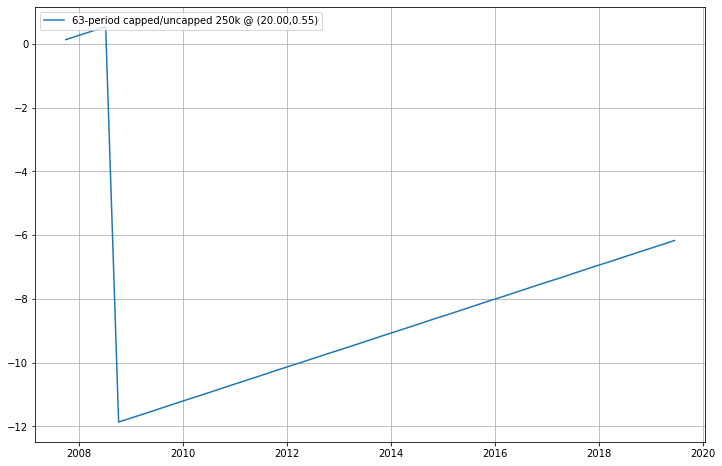

In [162]:
# Sell N-period capped/uncapped every N+1 days
start_date = '2007-10-03'
N = 63; K = 0.20; spread = 0.0055; vega_n = 250e3
trade_count = int(len(df.loc[start_date:])/(N+1))
trade_entries = np.arange(trade_count)*(N+1)
backtested = pd.Series(np.zeros(trade_count),index=df.loc[start_date:].index[trade_entries])
for idx,t in enumerate(trade_entries):
    S_t = df.loc[start_date:].iloc[t:t+N+1]
    backtested.iloc[idx] = capped_uncapped(S_t,K,2.5,spread,vega_n,const_var=const_var)
plot(-backtested.cumsum()/1e6,label='%d-period capped/uncapped %dk @ (%0.2f,%0.2f)'%(N,vega_n/1e3,K*100,spread*100))
legend(loc='upper left')

total pnl : 10.68m
pnl/year  : 1.07m
max draw  : -5.05m


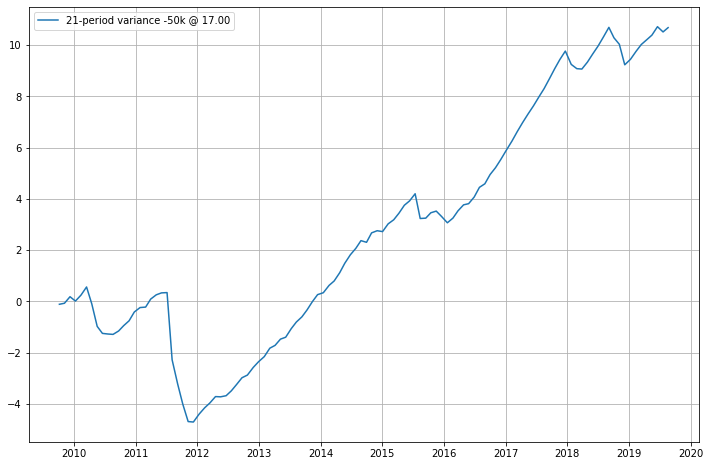

In [234]:
# Sell N-period uncapped variance every N+1 days
start_date = '2009-10-03'
N = 21; K = 0.17; vega_n = -50e3
trade_count = int(len(df.loc[start_date:])/(N+1))
trade_entries = np.arange(trade_count)*(N+1)
backtested = pd.Series(np.zeros(trade_count),index=df.loc[start_date:].index[trade_entries])
for idx,t in enumerate(trade_entries):
    S_t = df.loc[start_date:].iloc[t:t+N+1]
    backtested.iloc[idx] = core.variance_swap_payout(S_t,K,vega_n=vega_n)
plot(backtested.cumsum()/1e6,label='%d-period variance %dk @ %0.2f'%(N,vega_n/1e3,K*100))
legend(loc='upper left')
print('total pnl : %0.2fm'%(backtested.sum()/1e6))
print('pnl/year  : %0.2fm'%(backtested.sum()/1e6/len(df.loc[start_date:])*252))
print('max draw  : %0.2fm'%((backtested.cumsum()-backtested.cummax()).min()/1e6))

average pnl : 181k
max gain    : 456k
max loss    : -2,613k
win percent : 83.8%
pnl z-score : 0.52


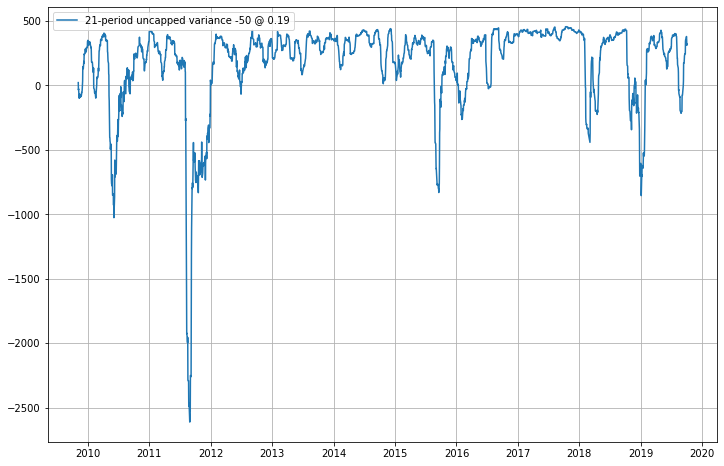

In [270]:
# Overall uncapped variance selling
start_date = '2009-10-03'
N = 21; K = 0.19; vega_n = -50e3

eval_func = lambda S_t: core.variance_swap_payout(pd.Series(S_t),K,vega_n=vega_n)

backtested = df.loc[start_date:].rolling(N+1).apply(eval_func, raw=False).iloc[N+1:]
plot(backtested/1e3, label='%d-period uncapped variance %d @ %0.2f'%(N,vega_n/1e3,K))
legend(loc='upper left')
print('average pnl : {:,.0f}k'.format(backtested.mean()/1e3))
print('max gain    : {:,.0f}k'.format(backtested.max()/1e3))
print('max loss    : {:,.0f}k'.format(backtested.min()/1e3))
print('win percent : {:,.1f}%'.format((len(backtested.loc[backtested > 0])/len(backtested))*100))
print('pnl z-score : {:.2f}'.format(backtested.mean()/backtested.std()))

average pnl : -82k
max gain    : 123k
max loss    : -20,419k
win percent : 98.1%
pnl z-score : -0.05


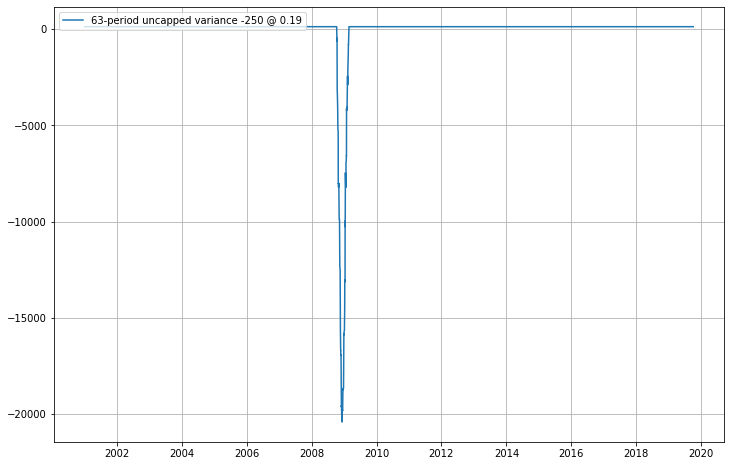

In [271]:
# Overall capped/uncapped selling
start_date = '2000-10-03'
N = 63; K = 0.19; cap = 2.5; spread = 0.005; vega_n = -250e3; const_var = True

eval_func = lambda S_t: capped_uncapped(pd.Series(S_t),K,cap,spread,vega_n,const_var=const_var)

backtested = df.loc[start_date:].rolling(N+1).apply(eval_func, raw=False).iloc[N+1:]
plot(backtested/1e3, label='%d-period uncapped variance %d @ %0.2f'%(N,vega_n/1e3,K))
legend(loc='upper left')
print('average pnl : {:,.0f}k'.format(backtested.mean()/1e3))
print('max gain    : {:,.0f}k'.format(backtested.max()/1e3))
print('max loss    : {:,.0f}k'.format(backtested.min()/1e3))
print('win percent : {:,.1f}%'.format((len(backtested.loc[backtested > 0])/len(backtested))*100))
print('pnl z-score : {:.2f}'.format(backtested.mean()/backtested.std()))